In [2]:
# === 1) Imports ===
import numpy as np
import pandas as pd
import wfdb
import ast

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


In [3]:
# === 2) Set PTB-XL path ===
# Put the dataset folder path here.
# IMPORTANT: make sure it ends with a slash "/" (or use Pathlib).
PTBXL_PATH = "./ptbxl/"

SAMPLING_RATE = 100  # use records100 (faster)
RANDOM_STATE = 42


In [4]:
# === 3) Load metadata and labels ===
Y = pd.read_csv(PTBXL_PATH + "ptbxl_database.csv", index_col="ecg_id")
Y["scp_codes"] = Y["scp_codes"].apply(ast.literal_eval)

agg_df = pd.read_csv(PTBXL_PATH + "scp_statements.csv", index_col=0)
agg_df = agg_df[agg_df["diagnostic"] == 1]

def aggregate_diagnostic(y_dic):
    out = []
    for key in y_dic.keys():
        if key in agg_df.index:
            out.append(agg_df.loc[key, "diagnostic_class"])
    return list(set(out))

Y["diagnostic_superclass"] = Y["scp_codes"].apply(aggregate_diagnostic)

Y[["patient_id","sex","age","strat_fold","diagnostic_superclass"]].head()


,patient_id,sex,age,strat_fold,diagnostic_superclass
ecg_id,,,,,
1,15709.0,1,56.0,3,[NORM]
2,13243.0,0,19.0,2,[NORM]
3,20372.0,1,37.0,5,[NORM]
4,17014.0,0,24.0,3,[NORM]
5,17448.0,1,19.0,4,[NORM]


In [5]:
# === 4) Load raw ECG waveforms (WFDB) ===
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        files = df["filename_lr"].values
    else:
        files = df["filename_hr"].values
    data = [wfdb.rdsamp(path + f)[0] for f in files]  # only signal array
    return np.array(data, dtype=object)  # each element is (time, 12)

X = load_raw_data(Y, SAMPLING_RATE, PTBXL_PATH)
print("Loaded records:", len(X), "Example shape:", X[0].shape)


Loaded records: 21837 Example shape: (1000, 12)


In [14]:
xflat = np.array([x.flatten() for x in X])  # flatten 2D arrays to 1D
xflat

array([[-0.119, -0.055, 0.064, ..., 0.143, -0.035, -0.12],
       [0.004, 0.138, 0.134, ..., -0.308, -0.231, -0.145],
       [-0.029, -0.079, -0.049, ..., 0.001, -0.018, 0.006],
       ...,
       [0.038, 0.024, -0.014, ..., -0.181, -0.105, 0.033],
       [-0.057, -0.057, 0.0, ..., 0.211, 0.374, -0.009],
       [-0.049, -0.025, 0.024, ..., 0.106, 0.047, -0.103]], dtype=object)

In [7]:
# === 5) Split (PTB-XL recommended) ===
# folds 1-8 train, fold 9 val, fold 10 test
train_idx = np.where(Y["strat_fold"].between(1, 8))[0]
val_idx   = np.where(Y["strat_fold"] == 9)[0]
test_idx  = np.where(Y["strat_fold"] == 10)[0]

X_train, X_val, X_test = X[train_idx], X[val_idx], X[test_idx]
y_train_list = Y.iloc[train_idx]["diagnostic_superclass"]
y_val_list   = Y.iloc[val_idx]["diagnostic_superclass"]
y_test_list  = Y.iloc[test_idx]["diagnostic_superclass"]

print("Train/Val/Test:", len(train_idx), len(val_idx), len(test_idx))


Train/Val/Test: 17441 2193 2203


In [8]:
# === 6) Choose a simple target (binary) ===
# Example: detect Myocardial Infarction (MI) vs not MI
TARGET = "MI"

y_train = y_train_list.apply(lambda labels: int(TARGET in labels)).to_numpy()
y_val   = y_val_list.apply(lambda labels: int(TARGET in labels)).to_numpy()
y_test  = y_test_list.apply(lambda labels: int(TARGET in labels)).to_numpy()

print("Positive rate (train):", y_train.mean())


Positive rate (train): 0.251648414655123


In [9]:
# === 7) Feature extraction (fast baseline) ===
# For each lead we compute 5 simple features: mean, std, min, max, RMS.
def feats_one_lead(x):
    x = np.asarray(x, dtype=float)
    x = x[np.isfinite(x)]
    if x.size == 0:
        return [0,0,0,0,0]
    return [x.mean(), x.std(), x.min(), x.max(), np.sqrt(np.mean(x**2))]

def feats_ecg(ecg):
    # ecg: (time, leads)
    ecg = np.asarray(ecg, dtype=float)
    out = []
    for lead in range(ecg.shape[1]):
        out.extend(feats_one_lead(ecg[:, lead]))
    return np.array(out, dtype=float)

X_train_feat = np.vstack([feats_ecg(e) for e in X_train])
X_val_feat   = np.vstack([feats_ecg(e) for e in X_val])
X_test_feat  = np.vstack([feats_ecg(e) for e in X_test])

print("Feature matrix:", X_train_feat.shape)


Feature matrix: (17441, 60)


VAL ROC-AUC: 0.8140963328933757
VAL Brier score: 0.14000162815500888
Chosen threshold: 0.21699906795887028
              precision    recall  f1-score   support

           0       0.91      0.67      0.77      1649
           1       0.45      0.80      0.57       544

    accuracy                           0.70      2193
   macro avg       0.68      0.74      0.67      2193
weighted avg       0.80      0.70      0.72      2193

Confusion matrix:
 [[1106  543]
 [ 108  436]]


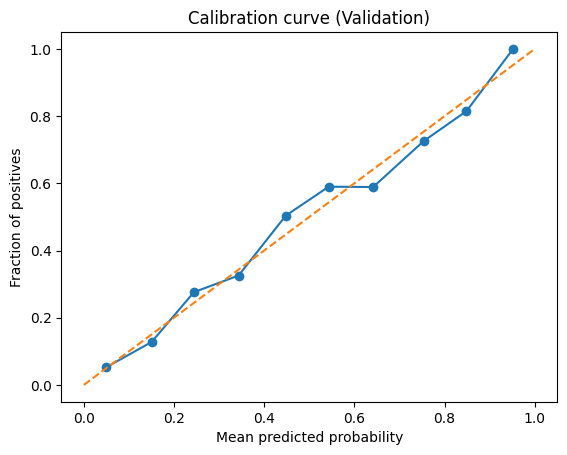

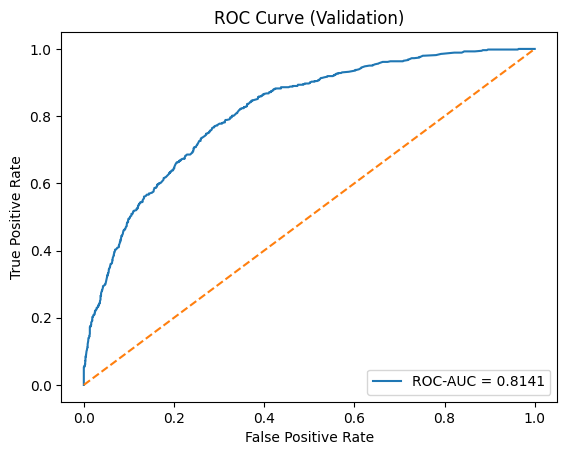

In [10]:
# Calibrated probability model (improves "truthfulness" of predicted probabilities)
# Assumes you already have: X_train_feat, y_train, X_val_feat, y_val, RANDOM_STATE

import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (
    roc_auc_score,
    brier_score_loss,
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    roc_curve
)

# -----------------------
# 1) Base model (use your tuned params if you have them)
# -----------------------
base_model = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", GradientBoostingClassifier(
        random_state=RANDOM_STATE,
        n_estimators=206,
        learning_rate=0.10618101782710437,
        max_depth=2,
        min_samples_leaf=20,
    )),
])

# -----------------------
# 2) Calibration wrapper
#    - "isotonic" often best with enough data
#    - use "sigmoid" if you want a simpler calibrator
# -----------------------
cal_model = CalibratedClassifierCV(
    estimator=base_model,
    method="isotonic",
    cv=3,
)

cal_model.fit(X_train_feat, y_train)

# -----------------------
# 3) Validation probabilities (calibrated)
# -----------------------
val_prob = cal_model.predict_proba(X_val_feat)[:, 1]

print("VAL ROC-AUC:", roc_auc_score(y_val, val_prob))
print("VAL Brier score:", brier_score_loss(y_val, val_prob))

# -----------------------
# 4) Choose threshold to reduce false positives (example: recall >= 0.80)
# -----------------------
prec, rec, thr = precision_recall_curve(y_val, val_prob)
thr = np.r_[thr, 1.0]

MIN_RECALL = 0.80
mask = rec >= MIN_RECALL
if not np.any(mask):
    raise ValueError("No threshold achieves the requested MIN_RECALL.")

chosen_threshold = thr[mask][np.argmax(prec[mask])]
print("Chosen threshold:", chosen_threshold)

val_pred = (val_prob >= chosen_threshold).astype(int)

print(classification_report(y_val, val_pred))
print("Confusion matrix:\n", confusion_matrix(y_val, val_pred))

# -----------------------
# 5) Calibration curve plot
# -----------------------
frac_pos, mean_pred = calibration_curve(y_val, val_prob, n_bins=10)

plt.figure()
plt.plot(mean_pred, frac_pos, marker="o")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration curve (Validation)")
plt.show()
# ROC curve
fpr, tpr, _ = roc_curve(y_val, val_prob)
auc = roc_auc_score(y_val, val_prob)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC-AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Validation)")
plt.legend(loc="lower right")
plt.show()


In [17]:
import numpy as np
from sklearn.metrics import precision_recall_curve, confusion_matrix, classification_report

# val_prob from your current best_model
val_prob = best_model.predict_proba(X_val_feat)[:, 1]

prec, rec, thr = precision_recall_curve(y_val, val_prob)
thr = np.r_[thr, 1.0]  # align lengths (last point)

MIN_RECALL = 0.80  # set target recall (e.g., 0.80, 0.85, 0.90)

mask = rec >= MIN_RECALL
if not np.any(mask):
    raise ValueError("No threshold achieves the requested MIN_RECALL.")

best_idx = np.argmax(prec[mask])
chosen_threshold = thr[mask][best_idx]

print("Chosen threshold:", chosen_threshold)
print("Precision at threshold:", prec[mask][best_idx])
print("Recall at threshold:", rec[mask][best_idx])

val_pred = (val_prob >= chosen_threshold).astype(int)
print(classification_report(y_val, val_pred))
print("Confusion matrix:\n", confusion_matrix(y_val, val_pred))


Chosen threshold: 0.4268125768840187
Precision at threshold: 0.4459183673469388
Recall at threshold: 0.8033088235294118
              precision    recall  f1-score   support

           0       0.91      0.67      0.77      1649
           1       0.45      0.80      0.57       544

    accuracy                           0.70      2193
   macro avg       0.68      0.74      0.67      2193
weighted avg       0.80      0.70      0.72      2193

Confusion matrix:
 [[1106  543]
 [ 107  437]]
